In [1]:
%load_ext autoreload
%autoreload 2

## Exploration of o2 content in T-S space
Considering whether o2 content in TS-space can reveal mechanisms of oxygen change over time, following [Zika et al (2021)](https://journals.ametsoc.org/view/journals/clim/34/9/JCLI-D-20-0355.1.xml) where they did it for heat content.  
The interesting potential is that we can break down o2 into its different "contributions" from temp, aou, and disequilibrium.

- [ ] Work on the mathematical framing here
- [ ] Take a look at o2 and o2sat in TS-space

***
Update 9.19.22  

Taking a look at the 1D volume distribution in oxygen space and its change over time.

***
Update 7.11.22  
Actually considering whether the answeer is simpler. O2 in TS space is not interesting. We want the geographical distribution of o2 change due to temp change and bio change. Each of these has a component due to material changes and redistribution. The o2sat piece will look just like temperature.

If we get material change in o2, and material change in o2sat; difference is material change in o2bio. Can we get material change from the Zika et al. approach but looking at volume in o2-salinity space?

$$\Delta \Phi = \Delta \Phi_{adv} + \Delta \Phi_{mat}$$

For O2, $\Delta\Phi = \Delta\Phi^{sat} + \Delta\Phi^{+}$; where $+$ includes both biological derived changes (i.e. oxygen utilisation) and disequilibrium changes.

So, for $\Phi = O_2$,
$$\Delta \Phi = \Delta \Phi^{sat}_{adv} + \Delta \Phi^{sat}_{mat} + \Delta \Phi^{+}_{adv} + \Delta \Phi^{+}_{mat}$$

$$\Delta \Phi^{+}_{mat} = \Delta \Phi - \Delta \Phi_{adv} - \Delta \Phi^{sat}_{mat}$$

$$\Delta \Phi^{+}_{mat} = \Delta \Phi_{mat} - \Delta \Phi^{sat}_{mat}$$

We can derive $\Delta \Phi_{mat}$ and $\Delta \Phi^{sat}_{mat}$ using the approach of Zika et al. $\Delta \Phi^{sat}_{mat}$ is effectively $\Delta \Theta_{mat}$; where $\Theta$ is heat content.

$$\Delta \Phi^{+}_{mat} = \Delta \Phi^{bio}_{mat} + \Delta \Phi^{dis}_{mat}$$

$\Delta \Phi^{bio}_{mat}$ could be recovered through comparison with $NO_3$

In [10]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt
import os
from dask.diagnostics import ProgressBar

In [9]:
config_id = 'ESM4_historical_D1'
dmget = True

ds = xr.Dataset()
if (config_id == 'ESM4_piControl_D') or (config_id == 'ESM4_historical_D1'):
    if config_id == 'ESM4_piControl_D':
        time = '03*'
    elif config_id == 'ESM4_historical_D1':
        time = '*'
        
    pathDict = {'pp':('/archive/oar.gfdl.cmip6/ESM4/DECK/'+config_id+'/'+
                        'gfdl.ncrc4-intel16-prod-openmp/pp'),
                'out':'ts',
                'local':'annual/5yr',
                'time':time}
    pathDict['ppname']='ocean_cobalt_omip_tracers_year_z_1x1deg'
    variables = ['o2','o2sat']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        if dmget:
            gu.core.issue_dmget(path)
        else:
            ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    
    pathDict['ppname']='ocean_annual_z_1x1deg'
    variables = ['thetao','so','volcello']
    for variable in variables:
        pathDict['add'] = variable
        path=gu.core.get_pathspp(**pathDict)
        if dmget:
            gu.core.issue_dmget(path)
        else:
            ds[variable] = gu.core.open_frompp(**pathDict)[variable]
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    if dmget:
        gu.core.issue_dmget(gridpath)
    else:
        grid = xr.open_dataset(gridpath)
    
if dmget==False:
    ds = ds.chunk({'time':1}).squeeze()

## Volume in oxygen space, and change over time

In [ ]:
o2_bins = np.arange(-0.03,0.45,0.01)
hs = histogram(ds['o2'],
               bins=[o2_bins],
               dim=['lon','lat','z_l'],
               weights=ds['volcello'])

In [ ]:
with ProgressBar():
    hs = hs.compute()

#### Time-mean distribution of oxygen content in TS space

In [87]:
thetao_bins = np.arange(-2,32,0.5)
so_bins = np.arange(32,38,0.1)
hs = histogram(ds['thetao'],ds['so'],
               bins=[thetao_bins,so_bins],
               dim=['lon','lat','z_l'],
               weights=ds['o2sat']*ds['volcello'])

In [88]:
with ProgressBar():
    hs = hs.compute()

[########################################] | 100% Completed | 20.6s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0, 0.5, 'log10(O2 content)')

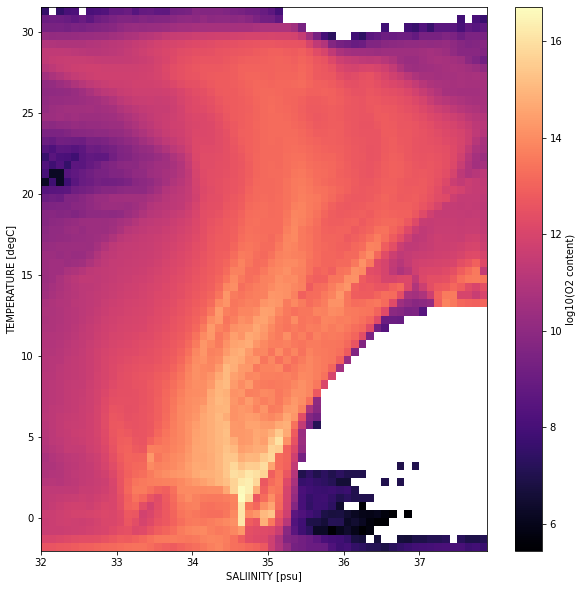

In [89]:
fig,ax = plt.subplots(figsize=(10,10))
x = hs['so_bin']
y = hs['thetao_bin']
c = np.log10(hs.mean('time'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='magma')
ax.set_xlabel('SALIINITY [psu]')
ax.set_ylabel('TEMPERATURE [degC]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('log10(O2 content)')

#### Change over time

Text(0, 0.5, 'Delta O2 content [mol s-1]')

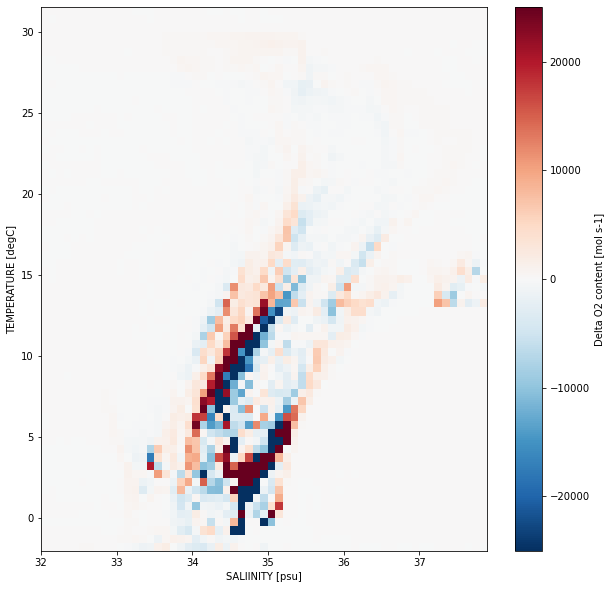

In [90]:
fig,ax = plt.subplots(figsize=(10,10))
x = hs['so_bin']
y = hs['thetao_bin']
te = slice(-20,-1)
ts = slice(0,20)
dt = hs['time'].isel(time=te).mean('time') - hs['time'].isel(time=ts).mean('time')
c = (hs.isel(time=te).mean('time') - hs.isel(time=ts).mean('time'))/((dt*1e-9).values.astype('float'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='RdBu_r',vmin=-0.25e5,vmax=0.25e5)
ax.set_xlabel('SALIINITY [psu]')
ax.set_ylabel('TEMPERATURE [degC]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('Delta O2 content [mol s-1]')

# Volume in O2-S space

In [38]:
o2 = ds['o2']
o2_bins = np.arange(-0.03,0.45,0.01)
so_bins = np.arange(28,40,0.1)
hs = histogram(ds['o2'],ds['so'],
               bins=[o2_bins,so_bins],
               dim=['lon','lat','z_l'],
               weights=ds['volcello'])

In [39]:
with ProgressBar():
    hs = hs.compute()

[########################################] | 100% Completed | 14.5s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0, 0.5, 'log10(volume)')

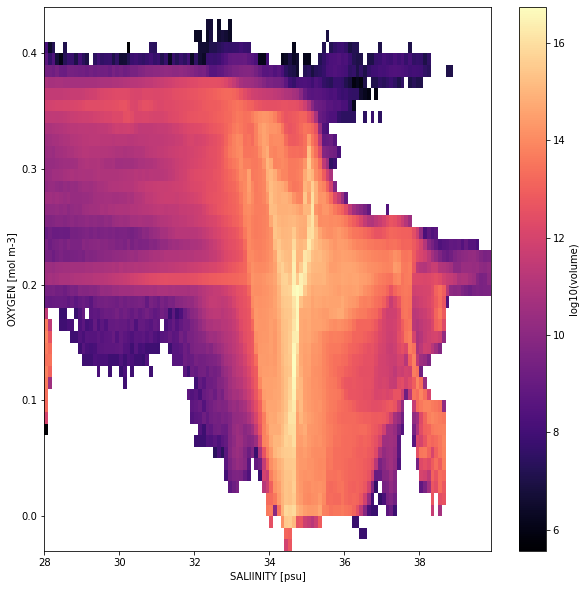

In [41]:
fig,ax = plt.subplots(figsize=(10,10))
x = hs['so_bin']
y = hs['o2_bin']
c = np.log10(hs.mean('time'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='magma')
ax.set_xlabel('SALIINITY [psu]')
ax.set_ylabel('OXYGEN [mol m-3]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('log10(volume)')

## O2sat and O2d (= O2-O2sat)

In [49]:
ds['o2d']=-ds['o2']+ds['o2sat']

o2_bins = np.arange(-0.03,0.45,0.01)
so_bins = np.arange(28,40,0.1)
hs = xr.Dataset()

oxygens = ['o2','o2sat','o2d']
for oxygen in oxygens:
    hsnow = histogram(ds[oxygen],ds['so'],
                      bins=[o2_bins,so_bins],
                      dim=['lon','lat','z_l'],
                      weights=ds['volcello'])
    hs[oxygen]=hsnow.rename({oxygen+'_bin':'o2_bin'})

In [50]:
with ProgressBar():
    hs = hs.compute()

[########################################] | 100% Completed | 21.3s


/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


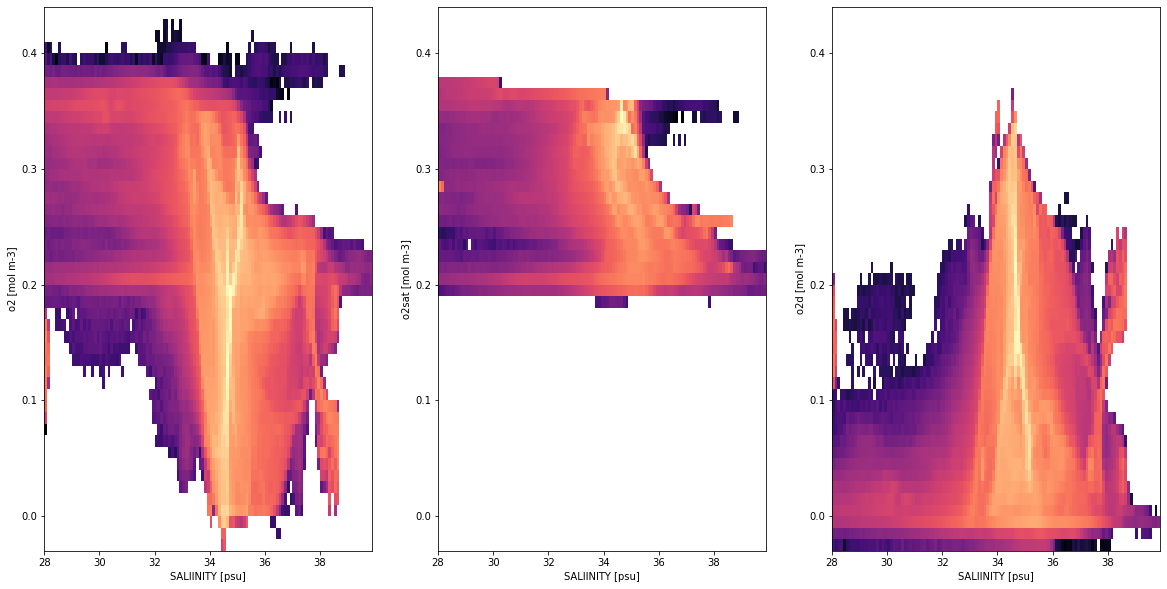

In [51]:
fig,ax = plt.subplots(figsize=(20,10),ncols=len(oxygens))
x = hs['so_bin']
y = hs['o2_bin']
for i,oxygen in enumerate(oxygens):
    axnow = ax.flat[i]
    hsnow = hs[oxygen]
    c = np.log10(hsnow.mean('time'))
    im = axnow.pcolormesh(x,y,c,shading='auto',cmap='magma')
    axnow.set_xlabel('SALIINITY [psu]')
    axnow.set_ylabel(oxygen+' [mol m-3]')
    # cb = plt.colorbar(im,ax=ax)
    # cb.ax.set_ylabel('log10(volume)')

Text(0, 0.5, 'Delta Volume [m3 s-1]')

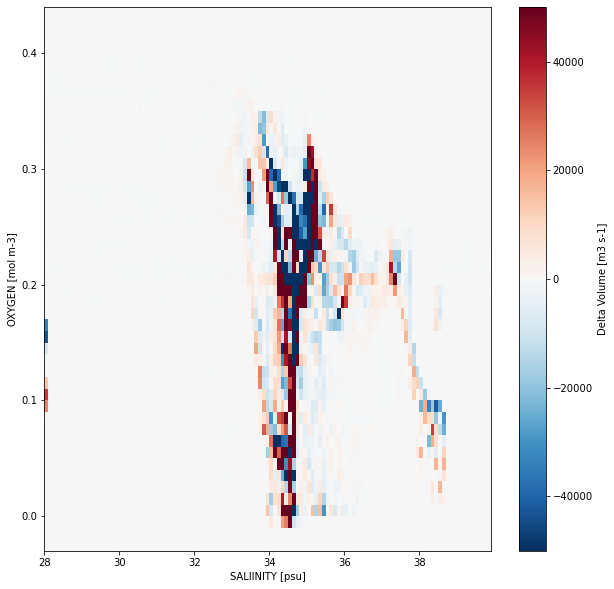

In [29]:
fig,ax = plt.subplots(figsize=(10,10))
x = hs['so_bin']
y = hs['o2_bin']
te = slice(-20,-1)
ts = slice(0,20)
dt = hs['time'].isel(time=te).mean('time') - hs['time'].isel(time=ts).mean('time')
c = (hs.isel(time=te).mean('time') - hs.isel(time=ts).mean('time'))/((dt*1e-9).values.astype('float'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='RdBu_r',vmin=-0.5e5,vmax=0.5e5)
ax.set_xlabel('SALIINITY [psu]')
ax.set_ylabel('OXYGEN [mol m-3]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('Delta Volume [m3 s-1]')

In [16]:
# Reproject in geographical space
hs = histogram(ds['o2'],ds['so'],
               bins=[o2_bins,so_bins],
               dim=['z_l'],
               weights=ds['volcello'])
hs = hs.chunk({'o2_bin':10,'so_bin':10})

In [23]:
To2 = 34.5
Tso = 0.2
Itime = 0
with ProgressBar():
    hsnow = hs.isel(time=Itime).sel(o2_bin=To2,so_bin=Tso,method='nearest')
    hsnow = hsnow.compute()

[########################################] | 100% Completed | 41.4s


# Oxygen change in geographical space

Text(0, 0.5, 'Delta OXYGEN [mol s-1]')

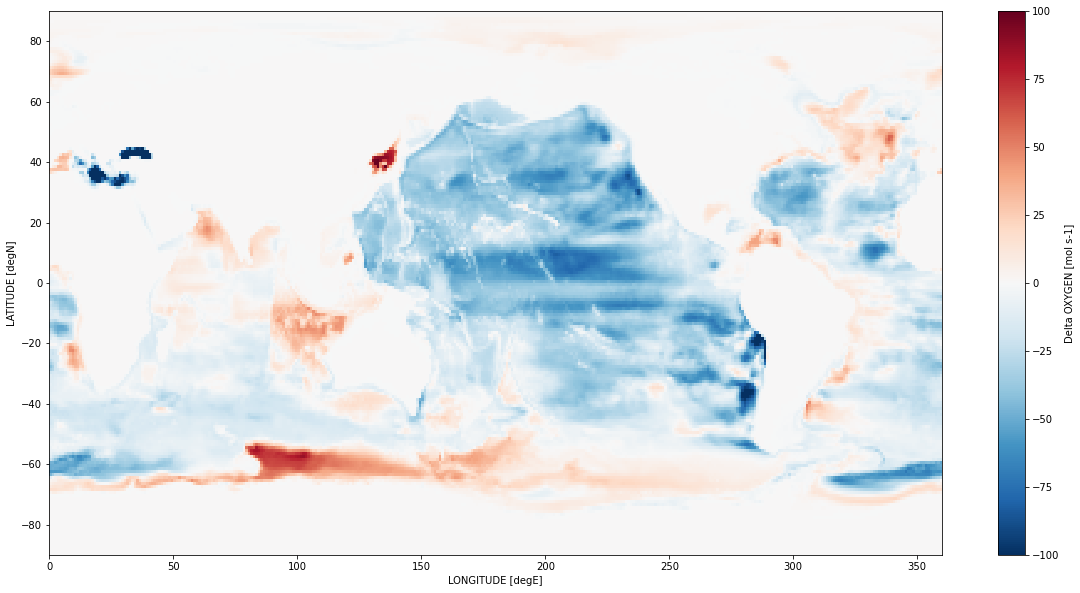

In [28]:
fig,ax = plt.subplots(figsize=(20,10))
x = ds['lon']
y = ds['lat']
te = slice(-20,-1)
ts = slice(0,20)
dt = ds['time'].isel(time=te).mean('time') - ds['time'].isel(time=ts).mean('time')
da = (ds['o2']*ds['volcello']).sum('z_l')
c = (da.isel(time=te).mean('time') - da.isel(time=ts).mean('time'))/((dt*1e-9).values.astype('float'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='RdBu_r',vmin=-100,vmax=100)
ax.set_xlabel('LONGITUDE [degE]')
ax.set_ylabel('LATITUDE [degN]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('Delta OXYGEN [mol s-1]')

Text(0, 0.5, 'Delta OXYGEN [mol s-1]')

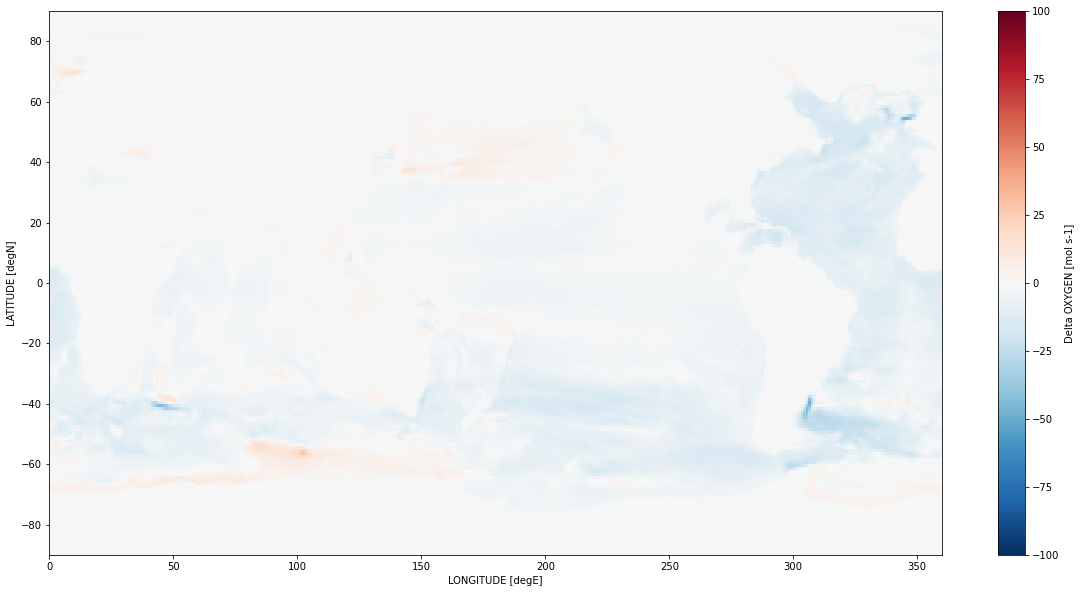

In [32]:
fig,ax = plt.subplots(figsize=(20,10))
x = ds['lon']
y = ds['lat']
te = slice(-20,-1)
ts = slice(0,20)
dt = ds['time'].isel(time=te).mean('time') - ds['time'].isel(time=ts).mean('time')
da = (ds['o2sat']*ds['volcello']).sum('z_l')
c = (da.isel(time=te).mean('time') - da.isel(time=ts).mean('time'))/((dt*1e-9).values.astype('float'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='RdBu_r',vmin=-100,vmax=100)
ax.set_xlabel('LONGITUDE [degE]')
ax.set_ylabel('LATITUDE [degN]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('Delta OXYGEN [mol s-1]')

Text(0, 0.5, 'Delta OXYGEN [mol s-1]')

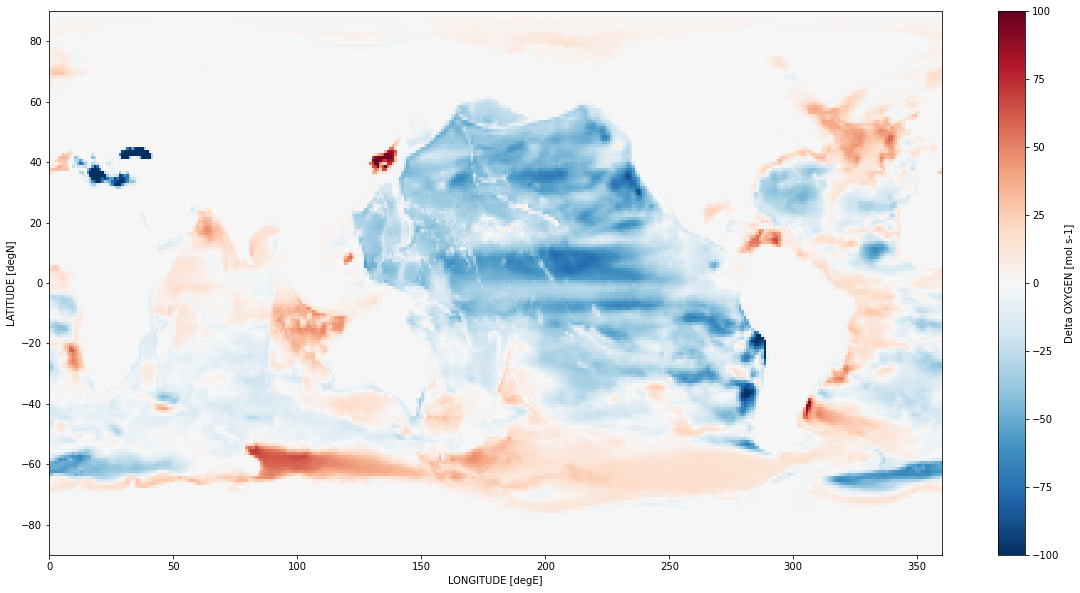

In [33]:
fig,ax = plt.subplots(figsize=(20,10))
x = ds['lon']
y = ds['lat']
te = slice(-20,-1)
ts = slice(0,20)
dt = ds['time'].isel(time=te).mean('time') - ds['time'].isel(time=ts).mean('time')
da = ((ds['o2']-ds['o2sat'])*ds['volcello']).sum('z_l')
c = (da.isel(time=te).mean('time') - da.isel(time=ts).mean('time'))/((dt*1e-9).values.astype('float'))
im = ax.pcolormesh(x,y,c,shading='auto',cmap='RdBu_r',vmin=-100,vmax=100)
ax.set_xlabel('LONGITUDE [degE]')
ax.set_ylabel('LATITUDE [degN]')
cb = plt.colorbar(im,ax=ax)
cb.ax.set_ylabel('Delta OXYGEN [mol s-1]')

In [31]:
ds['time'].isel(time=te)

<xarray.DataArray 'time' (time: 19)>
array([cftime.DatetimeNoLeap(1995, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1996, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1997, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1998, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2001, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2002, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2003, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2004, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2011, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2012, 7, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 7, 2, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1995-07-02 12:00:00 ... 2013-07-02 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds